In [2]:
import sys 
import numpy as np
from scipy.stats import randint
import pandas as pd 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score


C:\Users\Anurag sharma\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# DATA PREPROCESSING: 

In [3]:
mydata = pd.read_csv('C:\\Users\\Anurag sharma\\Desktop\\Internship\\WIP\\household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt') 
# data include 'nan' and '?' as a string. converted both to numpy nan.
# merged two columns 'Date' and 'Time' to 'dt'.
# converted in the above, the data to time-series type, by taking index to be the time.
# Specify that we have lots of RAM to avoid a warning that we are loading the data as an array of objects instead of an array of numbers, because of the ‘?’ values for missing data (low_memory=False).

In [4]:
mydata.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
mydata.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [37]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(mydata)
#profile = df.profile_report(title='Pandas Profiling Report')
profile.to_file("pandas_profiling_NILM.html")

In [34]:
rejected_variables = profile.get_rejected_variables(threshold=0.9)
rejected_variables


['Global_intensity']

# Going through histograms of each variable one can see that Global_active_power and Global_reactive_power as well as sub-metered power are skewed distribution towards small kilowatt values
# Voltage data follows Gaussian or normal distribution


# Global_intensity is highly correlated with Global_active_power , so it will not be used for analysis

In [7]:
mydata.drop(['Global_intensity'],axis=1).head() #dropping Global intensity

,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,0.0,1.0,17.0


# Since  most of columns have missing value we will do mean imputation

In [8]:
mean_value=mydata['Global_active_power'].mean()
mydata['Global_active_power']=mydata['Global_active_power'].fillna(mean_value)

In [9]:
columns = list(mydata.columns)
columns

['Global_active_power',
 'Global_reactive_power',
 'Voltage',
 'Global_intensity',
 'Sub_metering_1',
 'Sub_metering_2',
 'Sub_metering_3']

In [10]:
for i in columns:
    mean_value=mydata[i].mean()
    mydata[i]=mydata[i].fillna(mean_value)    
    
    

In [11]:
mydata.isnull().sum() #to make sure that there are not more any nan


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

# Time_Series_Analysis  : Resampling generates a unique sampling distribution on the basis of the actual data. We can apply various frequency to resample our time series data. Most commonly used time series frequency are – W : weekly frequency, M : month end frequency , SM : semi-month end frequency (15th and end of month) ,Q : quarter end frequency

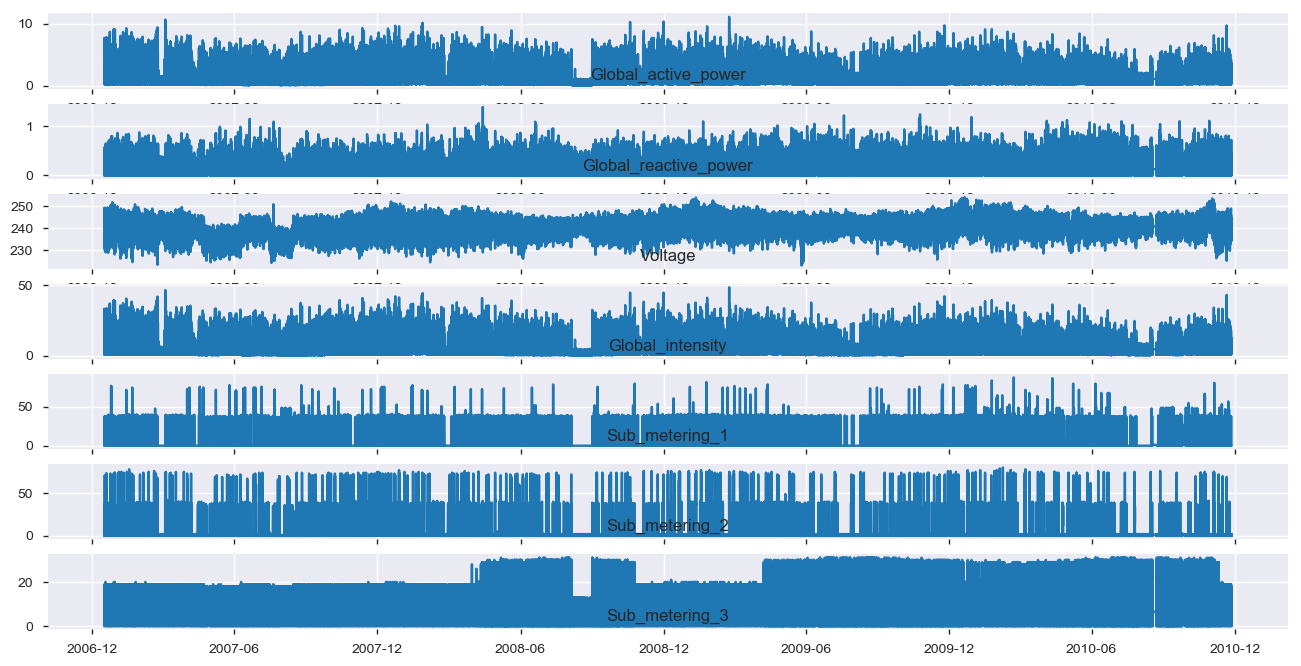

<Figure size 1600x800 with 0 Axes>

In [23]:
for i in range(len(columns)):
    plt.subplot(len(mydata.columns),1,i+1)
    column_name = mydata.columns[i]
    plt.plot(mydata[column_name])
    plt.title(column_name,y=0)
plt.show()
plt.savefig('Separate line plot for each of eight variable',format = 'pdf')

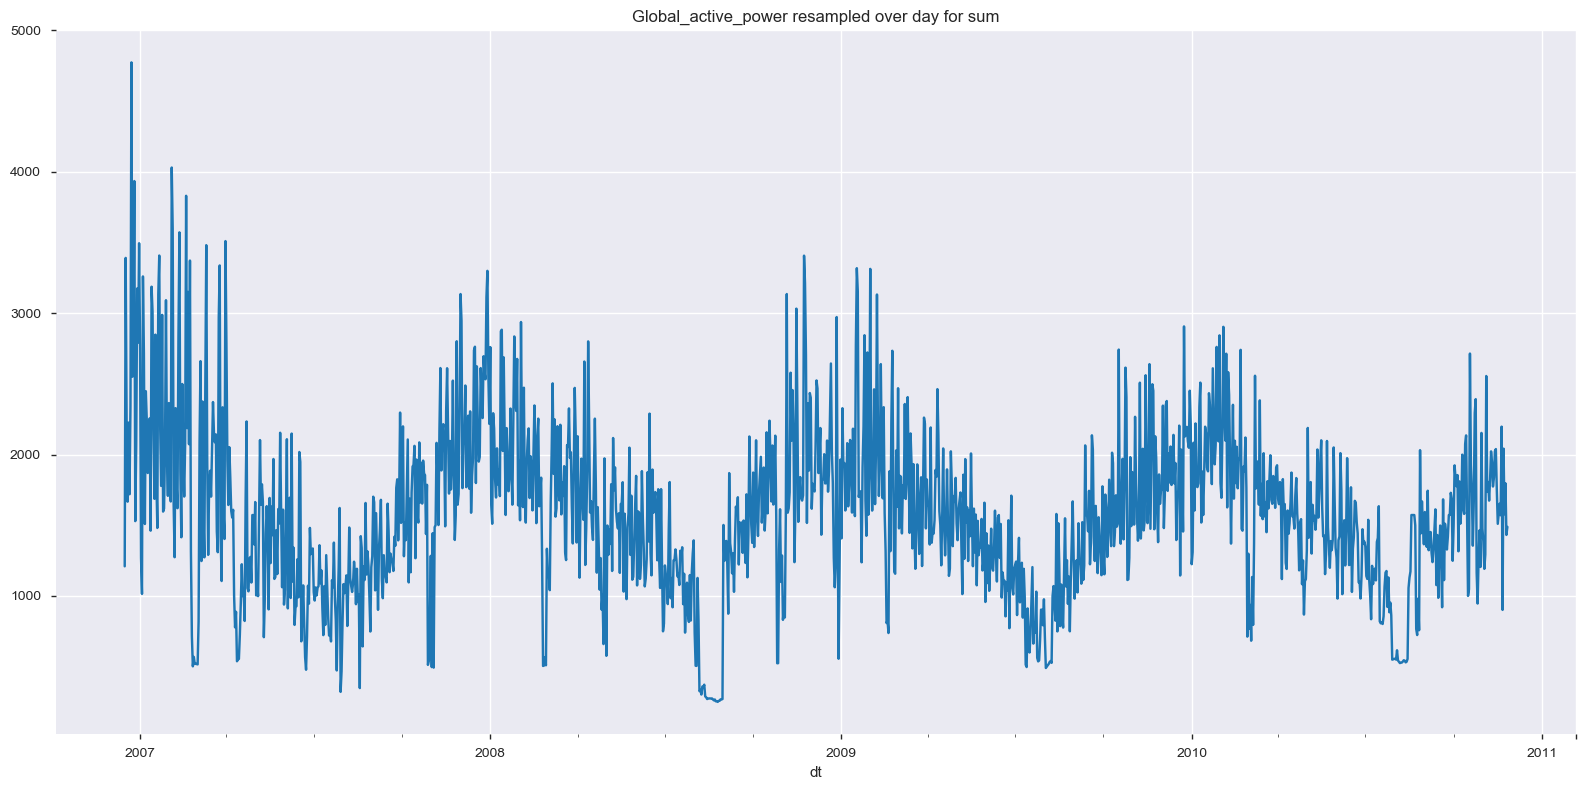

<Figure size 1600x800 with 0 Axes>

In [24]:
Daily_resampled_Global_active_power = mydata.Global_active_power.resample('D')
Daily_resampled_Global_active_power.sum().plot(title='Global_active_power resampled over day for sum')
plt.tight_layout()
plt.show()
plt.savefig('Global_active_power resampled over day for sum')




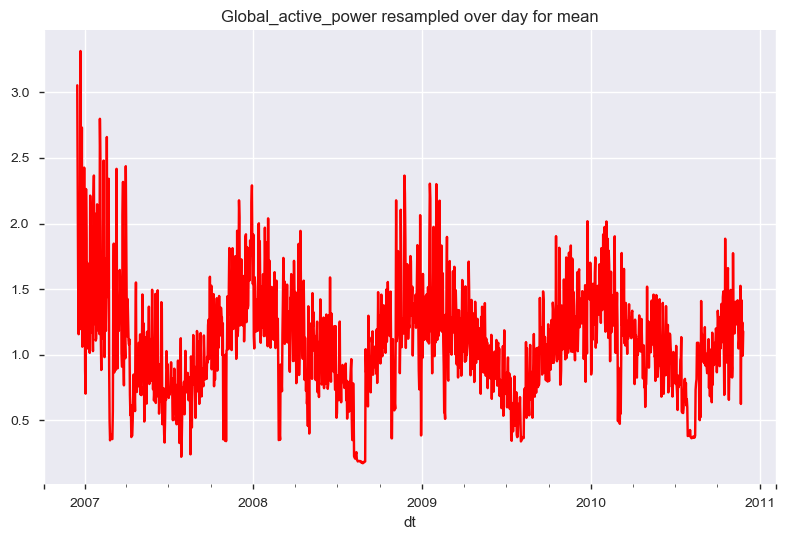

<Figure size 800x550 with 0 Axes>

In [14]:
Daily_resampled_Global_active_power.mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.tight_layout()
plt.show()
plt.savefig('Global_active_power resampled over day for mean')

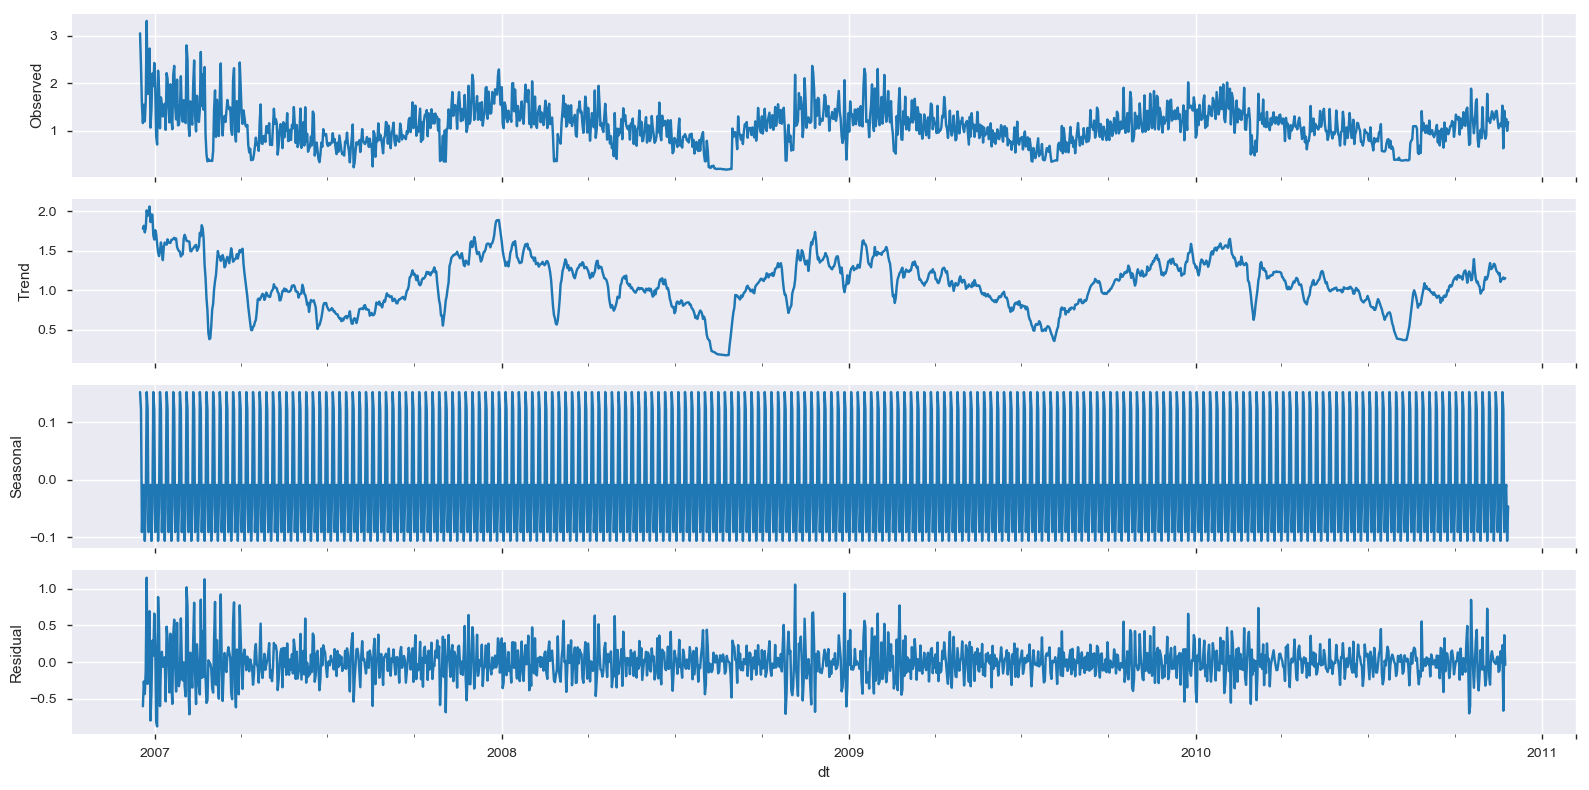

In [15]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 16,8
decomposition = sm.tsa.seasonal_decompose(Daily_resampled_Global_active_power.mean(),model = 'additive')
fig = decomposition.plot()
plt.show()

# Mean and standard deviation of  Global_active_power resampled over day


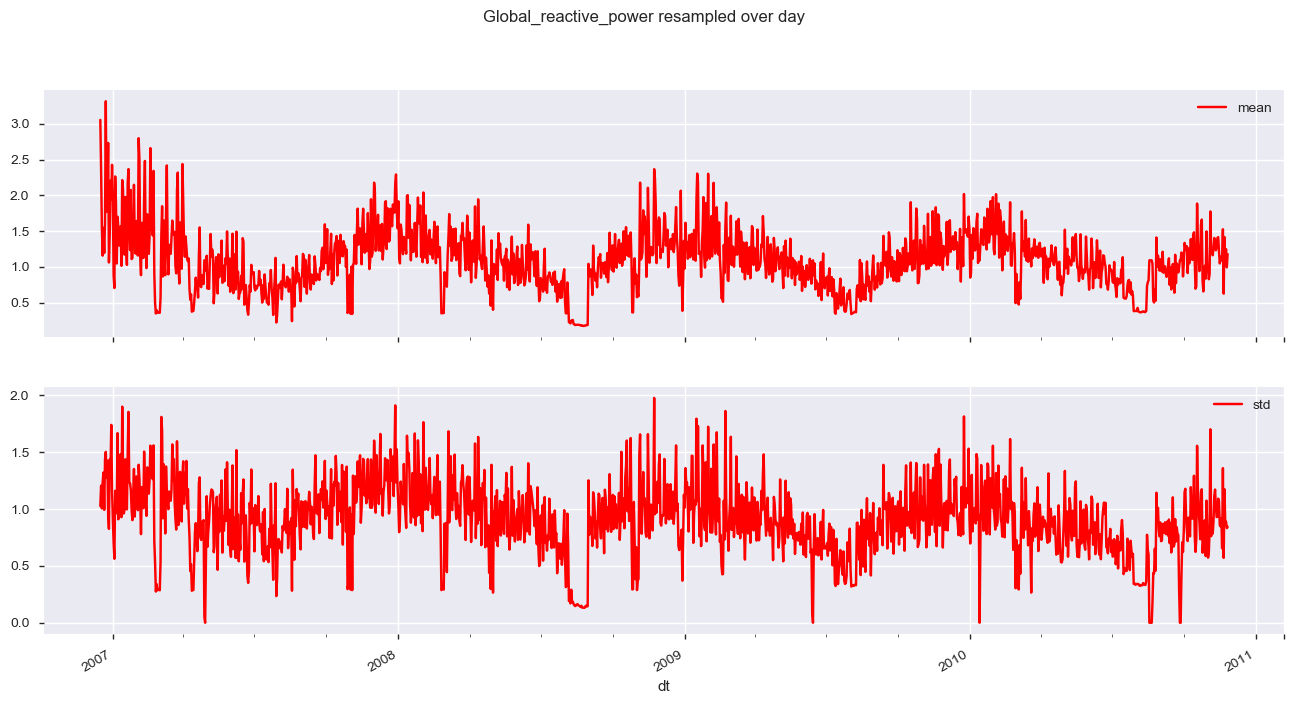

In [16]:
mydata.Global_active_power.resample('D').agg(['mean', 'std']).plot(subplots = True, title='Global_reactive_power resampled over day', color='red')
plt.show()

# Sum of 'Global_active_power' resampled over month and quarter

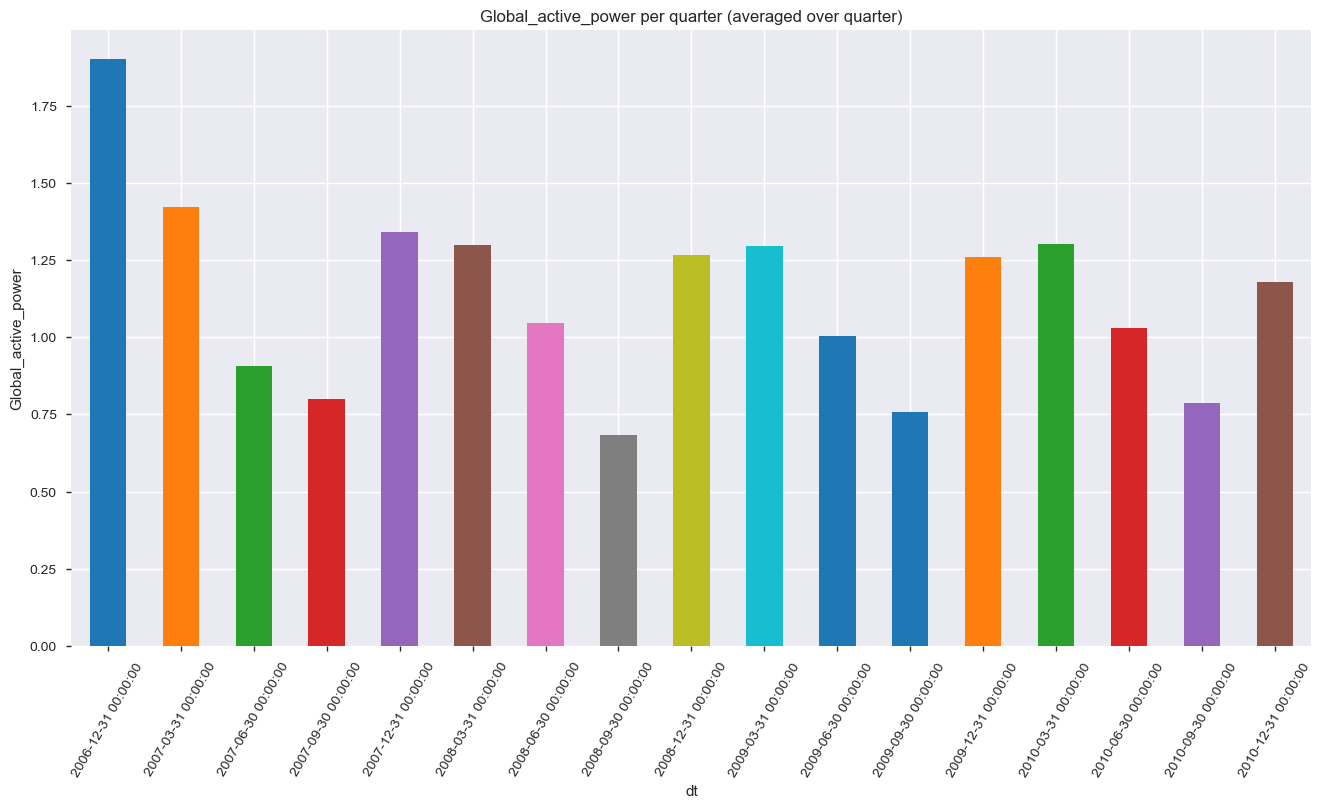

In [18]:
#resampled over quarter
mydata['Global_active_power'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per quarter (averaged over quarter)')
plt.show()

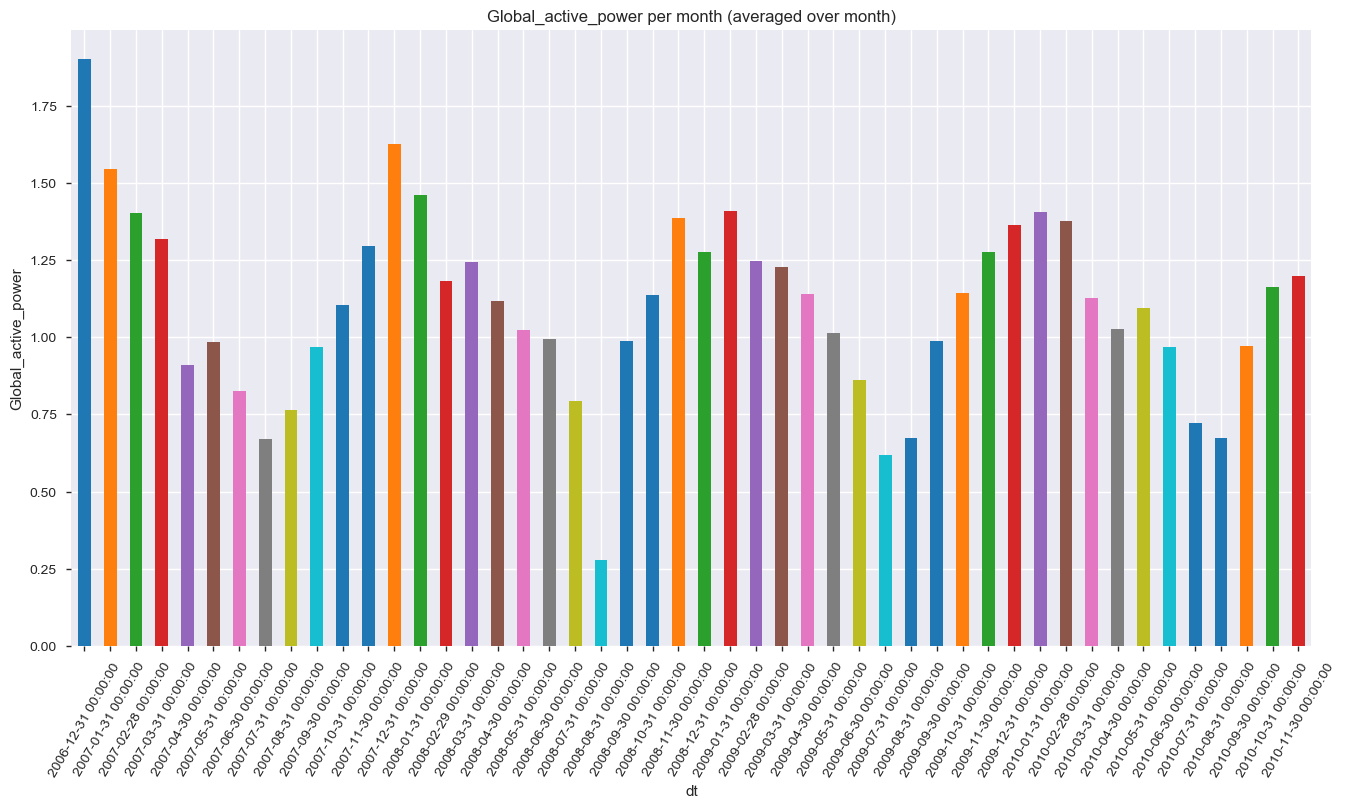

In [17]:
# Sum of 'Global_active_power' resampled over month
mydata['Global_active_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per month (averaged over month)')
plt.show()



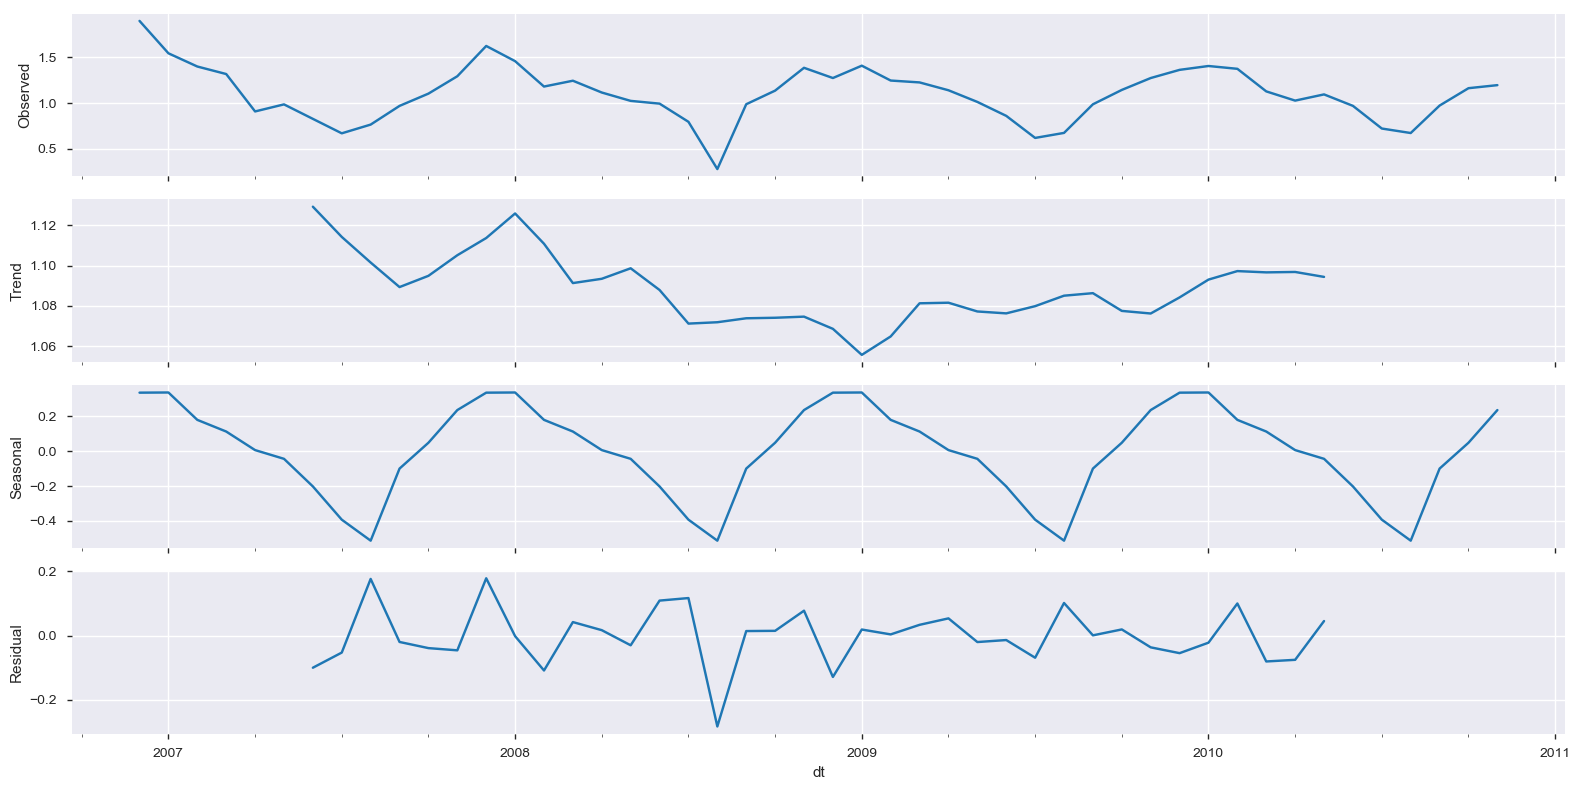

In [39]:
rcParams['figure.figsize'] = 16,8
decomposition = sm.tsa.seasonal_decompose(mydata['Global_active_power'].resample('M').mean(),model = 'additive')
fig = decomposition.plot()
plt.show()

# From above two plots it is clear that resampling over larger time inteval, will diminish the periodicity of system as we expect.

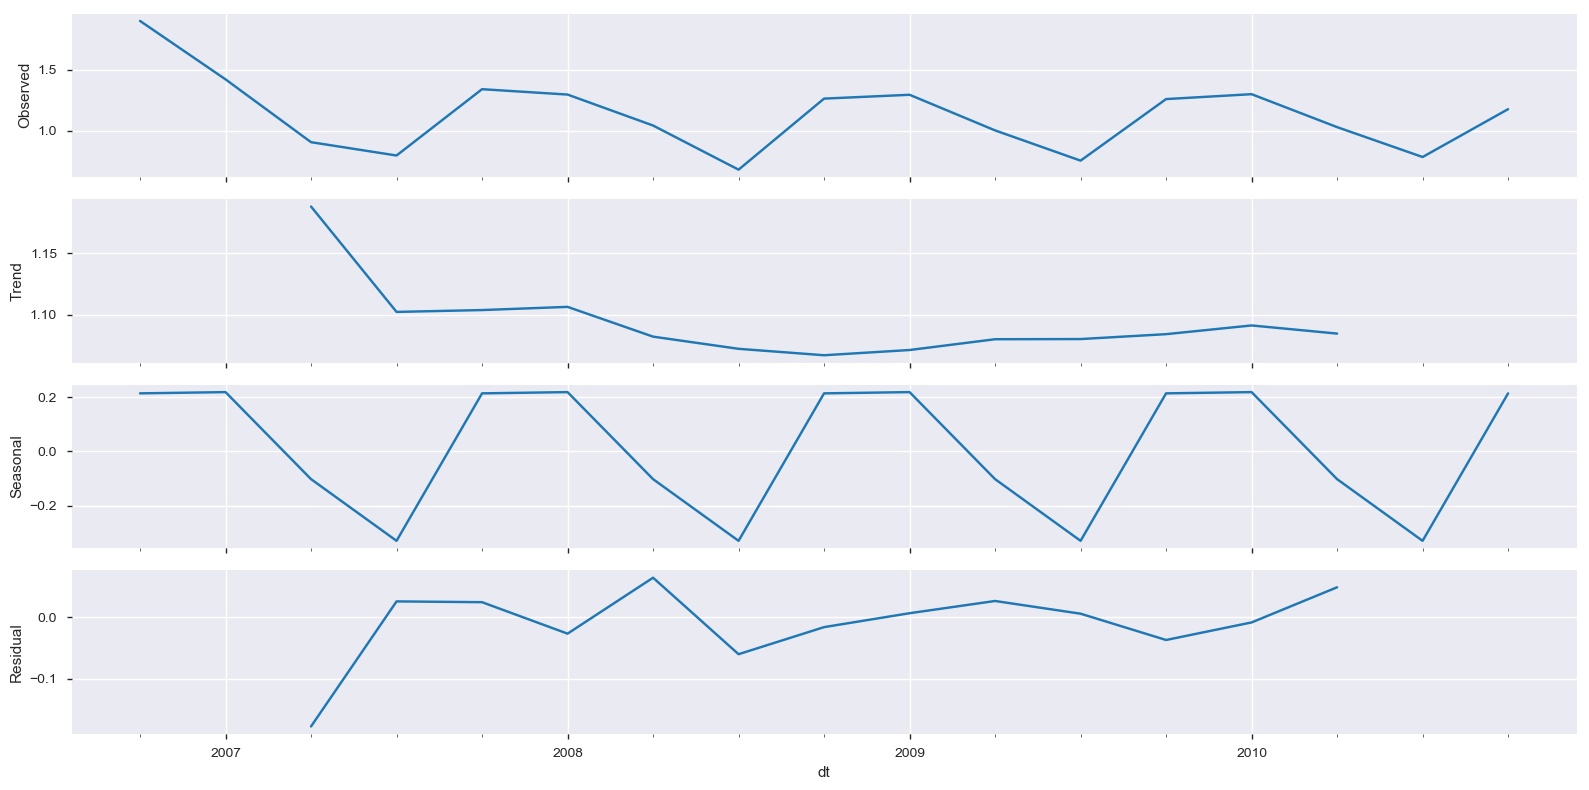

In [38]:
rcParams['figure.figsize'] = 16,8
decomposition = sm.tsa.seasonal_decompose(mydata['Global_active_power'].resample('Q').mean(),model = 'additive')
fig = decomposition.plot()
plt.show()